# Konvoluční síť pro klasifikaci obrázků

Cílem tohoto cvičení je vytvoření jednoduché konvoluční sítě pro klasifikaci obrázků do 10 tříd.

## Dataset

Jedná se o datovou sadu 50 000 barevných tréninkových obrázků 32x32 a 10 000 testovacích obrázků označených v 10 kategoriích. 

Další informace naleznete na https://www.cs.toronto.edu/~kriz/cifar.html

## Třídy
- 0 	airplane
- 1 	automobile
- 2 	bird
- 3 	cat
- 4 	deer
- 5 	dog
- 6 	frog
- 7 	horse
- 8 	ship
- 9 	truck


# Načtení datasetu
Opět se jedná o známý dataset, proto je v kerasu připravená funkce cifar10.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from keras.datasets import cifar10
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

Načtené třídy si pojmenujeme podle známého pořadí.

In [3]:
class_names=["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
num_classes = len(class_names)

# Průzkum dat
O datech zatím nic nevíme, proto se na ně podíváme.

Velikosti numpy polí nám ukazuje:
* Trénovacích dat je 50000
* Testovacích dat je 10000
* Obrázky jsou veliké 32x32
* Obrázky jsou barevné, protože máme 3 kanály RGB

In [4]:
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(Y_test.shape))

X_train: (50000, 32, 32, 3)
Y_train: (50000, 1)
X_test:  (10000, 32, 32, 3)
Y_test:  (10000, 1)


Můžeme si vypsat surová data pro první obrázek. Vidíme, že hodnoty jsou uloženy v datovém typu uint(8), který má rozsah 0..255.

In [5]:
X_train[0]

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]

Obrázků by mělo být 10 tříd, tak se podíváme na unikátní hodnoty matic Y_train a Y_test. Chceme, aby v nich byly zastoupeny všechny třídy.

In [7]:
print(np.unique(Y_train))
print(np.unique(Y_test))

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]


Dobrý dataset je vyvážený. V každé třídě by měl být podobný počet obrázků.

Vykreslíme si graf četnosti tříd.

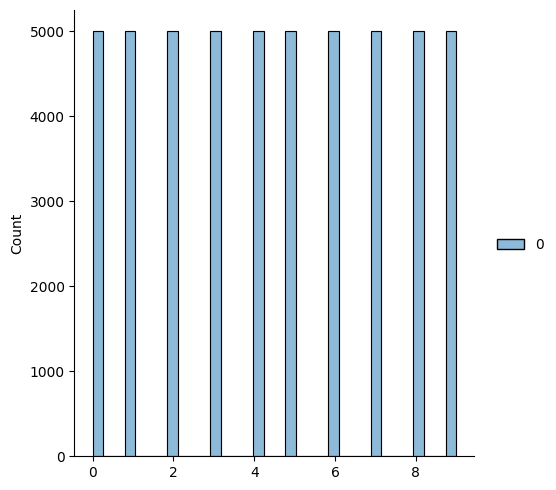

In [8]:
sns.displot(Y_train)

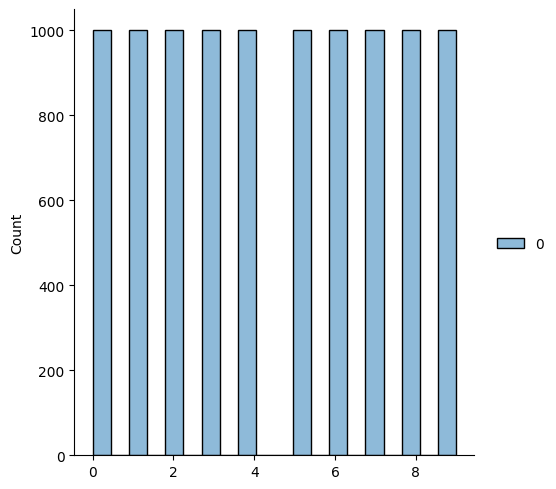

In [9]:
sns.displot(Y_test)

# Vizualizace dat
Jsou to obrázky. Proto si zobrazíme jejich náhled.

In [ ]:
def show_images (images, labels, rows=6, cols=10):
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
    plt.subplots_adjust(bottom=0)
    
    for idx in range (0, rows * cols):
        ridx=idx//cols
        cidx=idx % cols        
        ax= axes[ridx, cidx]
        ax.axis("off")
        ax.imshow(images[idx])
        label = class_names[labels[idx][0]]
        ax.set_title(f"{label}")        

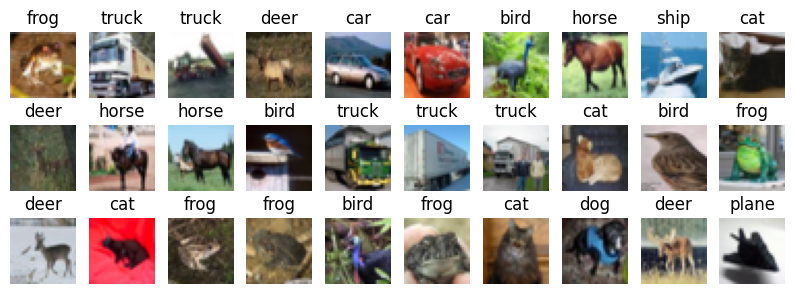

In [11]:
show_images(X_train, Y_train, 3, 10)

# Příprava dat
Rozsah hodnot je 0..255. Datový typ uint8.

Neuronové sítě lépe pracují se standardizovanými hodnotami okolo 0.

Proto změníme datový typ na float32 a data standardizujeme vydělení 255. Tím získáme rozsah 0..1

In [12]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train / 255
X_test = X_test / 255

Kontrolní zobrazení surových dat.

In [13]:
X_train[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

Výstupních kategorie ve vstupních datech opět uloženy jako číslo třídy.

Pro neuronové síť budeme chtít mít výstupní data v podobě vektoru. 

Provedeme binární encoding.

In [14]:
from keras.utils import to_categorical
num_classes = 10
Y_train = to_categorical(Y_train, num_classes)
Y_test = to_categorical(Y_test, num_classes)

Kontrolní zobrazení výstupních dat.

In [15]:
Y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

# Konvoluční neuronová síť

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input

Konvoluční neuronová síť je dopředná / sekvenční.

In [17]:
model = Sequential()

Na rozdíl od klasických sítí, konvoluční sítě pracují s prostorovou souvislostí vstupních dat. Proto vstupní data nebudeme převádět na jednorozměrný vektor, ale ponecháme je ve formě matice.

In [18]:
model.add(Input(shape=(32,32,3)))

Přidáme první konvoluční vrstvu.
* filters     - 32 konvolučních filtrů
* kernel_size - velikost konvolučních filtrů 3 x 3
* padding     - zarovnání same vede k rovnoměrnému vyplňování vlevo/vpravo nebo nahoru/dolů od vstupu
* activation  - aktivační funkce ReLU

In [19]:
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))

Přidáme další konvoluční vrstvu.

In [20]:
model.add(Conv2D(32, (3,3), padding='same', activation='relu'))

Za dvojici konvolučních vrstev následuje maxpolling vrstva.

Ta redukuje velikost matic pomocí poolu 2x2.

In [21]:
model.add(MaxPooling2D(pool_size=(2,2)))

Aby naše neuronová síť byla více odolná proti overfittingu, přidáme Dropout vrstvu.

Vrstva Dropout náhodně nastavuje vstupní neurony na 0, což pomáhá zabránit nadměrnému přizpůsobení sítě trénovacím datům.

Vstupy, které nejsou nastaveny na 0, se škálují o 1 / (1 - rate) tak, aby se součet všech vstupů nezměnil.

In [22]:
model.add(Dropout(0.3))

Pak se přidáme druhý blok konvolučních, maxpooling a dropout vrstev.

In [23]:
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

Třetí blok

In [24]:
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

Po sérii konvolučních vrstev je potřeba vystavět část sítě, která bude hodnoty převédět na kategorie.

Vrstva Flatten dosavadní vícerozměrná pole zploští na 1 rozměr.

In [25]:
model.add(Flatten())

Klasifikační část s plně propojenými vrstvami s aktivačními funkce relu.

In [26]:
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

Poslední vrstva má 10 výstupních neuronů, protože máme 10 tříd obrázků.

Používá se aktivační funkce softmax, která hodnoty převádí na pravděpodobnosti.

In [27]:
model.add(Dense(num_classes, activation='softmax')) 

Model si zobrazíme.

In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 550,570 (2.10 MB)

 Trainable params: 550,570 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
from keras_visualizer import visualizer 
visualizer(model, file_format='png', view=True)

# Učení

Nastavíme parametry učení.

In [30]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])

Vytvoříme Earlystop, abychom zbytečně netrénovali již natrénovanou síť.

In [31]:
early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=30)

Spustíme trénování sítě.

In [32]:
history = model.fit(X_train, Y_train, batch_size=64, epochs=15, callbacks=[early_stop])

Epoch 1/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 54ms/step - accuracy: 0.2448 - loss: 1.9830
Epoch 2/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.4757 - loss: 1.4429
Epoch 3/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step - accuracy: 0.5575 - loss: 1.2389
Epoch 4/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.6032 - loss: 1.1225
Epoch 5/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.6256 - loss: 1.0624
Epoch 6/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 56ms/step - accuracy: 0.6549 - loss: 0.9872
Epoch 7/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 45s 57ms/step - accuracy: 0.6693 - loss: 0.9426
Epoch 8/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 44s 57ms/step - accuracy: 0.6853 - loss: 0.8960
Epoch 9/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.6960 - loss: 0.8783
Epoch 10/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.7024 - loss: 0.8607
Epoch 11/15
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 54ms/step - accuracy: 0.7165 - loss: 0.8232
Epoch 12/15
782/782 ━━━━━━━━━━

Natrénovanou síť uložíme do souboru pro pozdější použití.

In [33]:
model.save('classification_model_cifar10.keras')

# Historie učení
Opět je dobré se podívat na proces učení, zda klesá hodnota nákladové funkce.

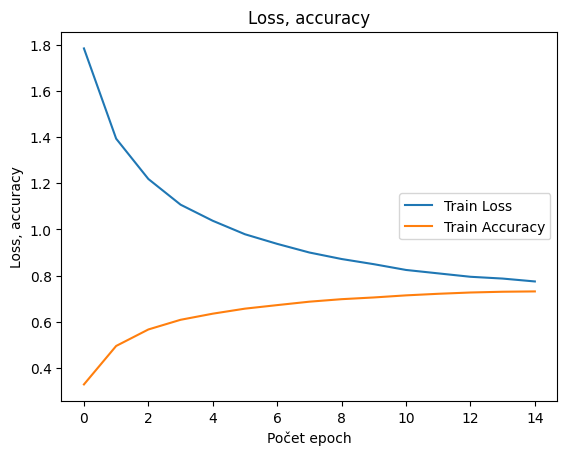

In [34]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.legend(loc="right")
plt.title('Loss, accuracy')
plt.ylabel('Loss, accuracy')
plt.xlabel('Počet epoch')
plt.show()

# Ověření modelu
Natrénovaný model musíme ověřit na trénovacích datech.

In [35]:
model = keras.models.load_model('classification_model_cifar10.keras')

In [36]:
Y_pred = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


Porovnáme predikci pro první obrázek

In [37]:
Y_pred[0]

array([9.3767572e-05, 8.7892389e-05, 1.8051908e-03, 8.6267328e-01,
       5.7407899e-04, 9.4492555e-02, 3.8711235e-02, 4.2913633e-04,
       1.0603894e-03, 7.2514384e-05], dtype=float32)

se správnou odpovědí.

In [38]:
Y_test[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

Výsledek dostáváme jako vektor pravdědpobností. Proto jednu odpověď získáme vyhledáním maxima.

In [39]:
Y_pred_best_answer = np.argmax(Y_pred, axis=-1)
Y_pred_best_answer

array([3, 8, 8, ..., 5, 1, 7])

Totéž provedeme s testovacími odpovědmi (realita).

Ideálně se obě pole rovnají.

In [40]:
Y_test_best_answer=np.argmax(Y_test, axis=-1)
Y_test_best_answer

array([3, 8, 8, ..., 5, 1, 7])

Vykreslíme se confusion matrix

<Axes: >

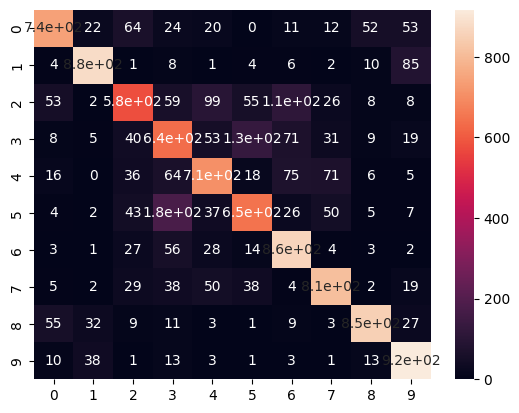

In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score
cf_matrix=confusion_matrix(Y_test_best_answer, Y_pred_best_answer)
sns.heatmap(cf_matrix, annot=True)

Zobrazíme si hodnotící parametry
* R2
* Accuracy

In [42]:
from sklearn.metrics import r2_score
r2 = r2_score(Y_test_best_answer, Y_pred_best_answer)
print('R2 score: {}'.format(r2))

R2 score: 0.5237333333333334


In [43]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print (f"Loss function: {scores[0]}")
print (f"Accuracy: {scores[1]}")

Loss function: 0.6824360489845276
Accuracy: 0.7631000280380249


Můžeme si zobrazit přesnosti pro jednotlivé třídy obrázků.

In [44]:
class_correct, class_count = [0]*10, [0]*10

for i in range(Y_test.shape[0]):    
    if (Y_test_best_answer[i] == Y_pred_best_answer[i]):
        class_correct[Y_test_best_answer[i]] +=1
    class_count[Y_test_best_answer[i]] += 1
    
for i in range(10):
    print (f"Accuracy for {class_names[i]}: {class_correct[i]/class_count[i]:.2%}") 

Accuracy for plane: 74.20%
Accuracy for car: 87.90%
Accuracy for bird: 57.70%
Accuracy for cat: 63.50%
Accuracy for deer: 70.90%
Accuracy for dog: 64.70%
Accuracy for frog: 86.20%
Accuracy for horse: 81.30%
Accuracy for ship: 85.00%
Accuracy for truck: 91.70%


Zajimavé může být zobrazení špatných odpovědí.

In [45]:
def show_wrong_predictions(X_test, Y_test, Y_pred, rows=5, cols=5):        
    idx = 0
    max_examples = rows * cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows), constrained_layout=True)    
    for i in range(Y_test.shape[0]):    
        if (Y_test[i] != Y_pred[i]):                                    
            ridx=idx // cols
            cidx=idx % cols            
            ax = axes[ridx, cidx]
            ax.axis("off")
            ax.imshow(X_test[i].reshape(32,32,3), cmap="gray_r")
            ax.set_title(f"{class_names[Y_test[i]]} != {class_names[Y_pred[i]]}")
            idx +=1
            if (idx == max_examples):
                break

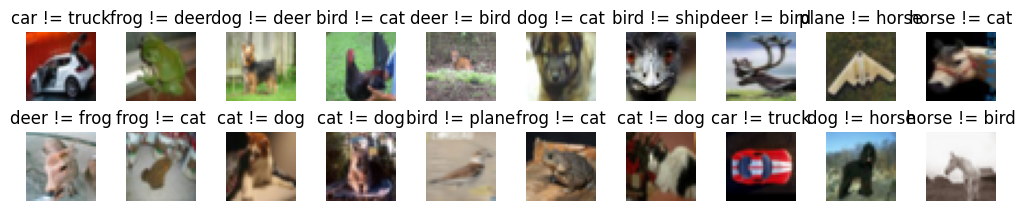

In [46]:
show_wrong_predictions(X_test, Y_test_best_answer, Y_pred_best_answer, 2, 10)